# Omega implementation of Peroxisome Dynamics

In this notebook we explore the application of Omega to a system modeling peroxisome dynamics. We use experimental data to condition the model and create the conditions of the model at the time the experiment was conducted. Once conditioned on the experimental data, we can use Omega to make interventions and answer counterfactual statements, such as "Given we saw the observed organelle counts, what would the counts have been if we added 5 organelles at time x".

In [1]:
## Load Packages
using Omega
using StatsBase
using Random
using Plots
using Distributions
using CSV
using DataFrames
using Flux
using DataStructures

┌ Info: Precompiling BenchmarkTools [6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf]
└ @ Base loading.jl:1192
┌ Warning: Module JSON with build ID 28048663874804 is missing from the cache.
│ This may mean JSON [682c06a0-de6a-54ab-a142-c8b1cf79cde6] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:947
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1192
rec_backtrace at /home/Administrator/buildbot/worker/package_win64/build/src/home/Administrator/buildbot/worker/package_win64/build/src\stackwalk.c:94
record_backtrace at /home/Administrator/buildbot/worker/package_win64/build/src/home/Administrator/buildbot/worker/package_win64/build/src\task.c:246
jl_throw at /home/Administrator/buildbot/worker/package_win64/build/src/home/Administrator/buildbot/worker/package_win64/build/src\task.c:577
jl_bounds_error_ints at /home/Administrator/buildbot/worker/package_win64/build/src/home/Administrator/buildbot/worker/package_win64

## Load dataset

Our experimental data is observed organelle counts for 13 cells over 3 different days.

In [2]:
day1 = CSV.read("C:/Users/Devon Kohler/Documents/Northeastern/Research/Causal_Inference/SDE_inference/Experimental_Data/Data/Day1/all.dat", DataFrame)
day2 = CSV.read("C:/Users/Devon Kohler/Documents/Northeastern/Research/Causal_Inference/SDE_inference/Experimental_Data/Data/Day2/all.dat", DataFrame)
day3 = CSV.read("C:/Users/Devon Kohler/Documents/Northeastern/Research/Causal_Inference/SDE_inference/Experimental_Data/Data/Day3/all.dat", DataFrame)
print()

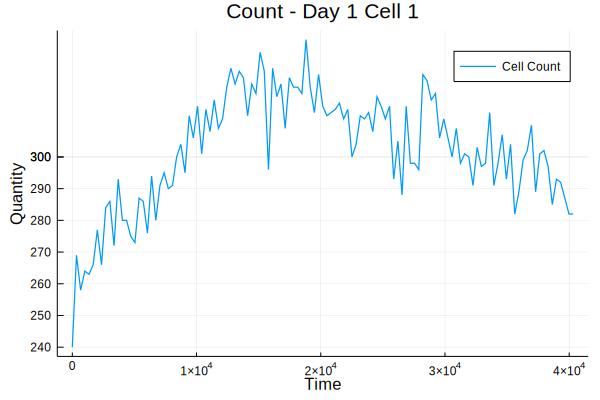

In [3]:
plot(day1[day1.Cell .== 1, :time],
    day1[day1.Cell .== 1, :count],
    title = "Count - Day 1 Cell 1",
    xlabel = "Time",
    ylabel = "Quantity",
    label = "Cell Count",
    lw = 1.25)

## Simple Model Formulation

We first apply Omega to a simple one equation model of organelle counts. The model is derived as follows.

### Model derivation

Given joint effect of three stochastic processes, the probabiliy $p(x, t)$ that the count equals x at time t is governed by the following equation

$$\frac{dp(x,t)}{dt} = [k_d + k_f(x-1)]p(x-1,t) + [\gamma(x+1)]p(x+1,t)-[k_d+(k_f + \gamma)x]p(x,t)$$

This can be further reformulated as an SDE:

$$dx(t) = [k_d + (k_f - \gamma)x(t)]dt + [k_d + (k_f + \gamma)x(t)]dW(t)$$

Where $W(t)$ is Brownian motion. Finally this equation can be solved with the Euler-Maruyama method.

$$x_{t+1} = [k_d + (k_f - \gamma)x_t]\Delta t + [k_d + (k_f + \gamma)x(t)]\sqrt{\Delta t}Z$$

$$Z \sim N(0,1)$$

Since we know $Z$ is a random variable, $x_{t+1}$ must also be a random variable.

### Omega Implementation

We take the rate parameters from the paper "Statistical Inference of Peroxisome Dynamics" by Cyril Galitzine, Pierre M. Jean Beltran, IleanaM.Cristea, and Olga Vitek. These are as follows:

$k_d = .000215, k_f = .0001, \gamma = .000105$


In [4]:
## Random variable for next step value
function x_sim(rng, n, diff_t)

    ## Parameters
    kd = .000215
    kf = .0001
    g = .000105

    ## Starting Value
    x = sim_steps[n](rng)

    ## Random var formula
    x_next = (kd + (kf - g)*x)*diff_t + (kd + (kf + g)*x)*sqrt(diff_t)*normal(rng,1,1)

    push!(x_vals, x + x_next)
    return x + x_next
end

x_sim (generic function with 1 method)

With the model formulated as single equation, we can use Omega to implement a single function as a random variable. The simplicity of the model makes testing Omega's functionality much easier.

#### Basic Simulation

Here we start with a simple Omega simulation. No experimental data is used in this step.

Note: We start the simulation at count = 240, which is where Cell 1 Day 1 starts.

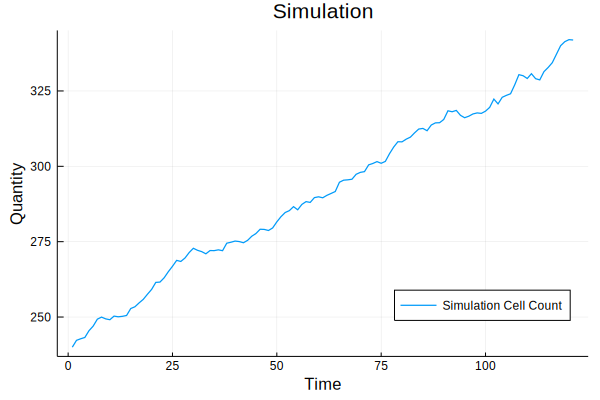

In [5]:
starting_val = 240.
starting_val_rand_var = normal(240., .0001)

x_vals = Any[]
push!(x_vals, starting_val)
sim_steps = Any[]
push!(sim_steps, starting_val_rand_var)

N = 121
for n in 2:N
    sim = ciid(x_sim, n-1, 336)
    push!(sim_steps, sim)
end

Random.seed!(12)
sim_samples = rand(Tuple(sim_steps), 1, alg = RejectionSample)

plot([i for i in sim_samples[1]],
    title = "Simulation",
    xlabel = "Time",
    ylabel = "Quantity",
    label = "Simulation Cell Count",
    lw = 1.25,
    legend = :bottomright)

We can compare this simulation to what we saw in the Cell 1 Day 1 experimental data.

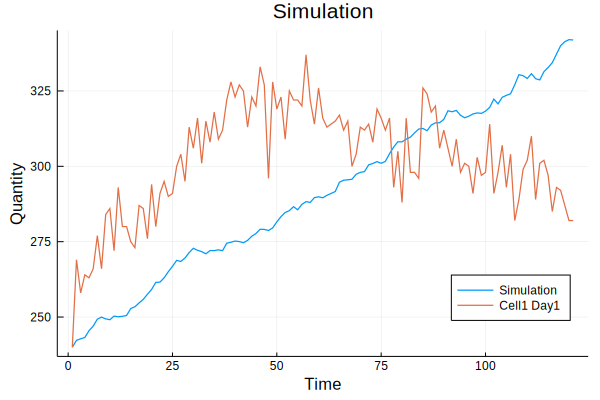

In [6]:
day1_cell1 = day1[day1.Cell .== 1, :count]
plot_counts = [i for i in sim_samples[1]]
plot(hcat(plot_counts, day1_cell1),
    title = "Simulation",
    xlabel = "Time",
    ylabel = "Quantity",
    label = ["Simulation" "Cell1 Day1" ],
    lw = 1.25,
    legend = :bottomright)

We can clearly see our experimental data and simulation data are very different. In order to make a simulation follow the general trace of the experiment, we need to use the conditioning functionality in Omega.

#### Conditioned Simulation

Conditioning the model on observed data seems straightforward in theory, but is a major complication in implementation. Conditioning on exact values is impossible because our simulation will evaluate to a round number. In other words 240.1 does not equal 240. Thus we need to use soft conditioning which will allow for reasonably close values to satisfy the condition. What counts as a close value is another complication.

An important aspect of soft conditioning in Omega is the kernel used to measure distance and the sampling algorithm. The default kernel in Omega is the squared exponential kernel. The default parameter for this kernel is not restrictive enough, causing the conditioned simulation to not follow the experimental data. In contrast, when tuning the kernal too tightly the simulation will never converge to the required values. Finding the right value for the kernel requires tuning to the specific problem. There are other kernels built into Omega but kse is found to be the best at this time.

In terms of the sampling algorithm, Omega provides a variety of built in algorithms including Rejection Sampling, Hamiltonian Monte Carlo, Single Site Metropolis Hastings, and No U-Turn Sampler. In addition Omega has an algorithm named Replica which samples from multiple temperatures and allows for easier tuning of the alpha parameter.

temps = [2.06115e-9, 4.53999e-5, 1.0, 22026.5]
plast = -7.547928469744012e-5
plast = -1.5037151839983123
plast = -47941.59062113757
plast = -1.063289504891049e9


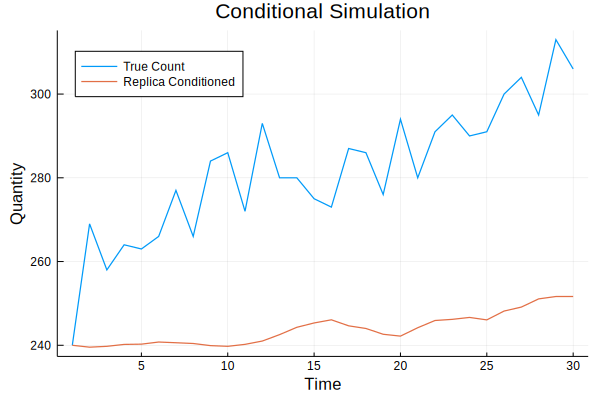

In [11]:
x_vals = Any[]
push!(x_vals, starting_val)
sim_steps = Any[]
push!(sim_steps, starting_val_rand_var)

N = 30
for n in 2:N
    sim_ = ciid(x_sim, n-1, 336)
    sim = cond(sim_, sim_ ==ₛ day1_cell1[n])
    push!(sim_steps, sim)
end

Random.seed!(25)
sim_samples = rand(Tuple(sim_steps), 1, alg = Replica)
sim_samples = [sim_samples[1][x] for x in 1:length(sim_samples[1])]#.data

plot(hcat(day1_cell1[1:30], sim_samples),
    title = "Conditional Simulation",
    xlabel = "Time",
    ylabel = "Quantity",
    label = ["True Count" "Replica Conditioned"],
    lw = 1.25,
    legend = :topleft)

Using Replica with base temperature parameters does not produce a trace that is close to the conditioned trace. Can we adjust the temperature values?

temps = [100, 1000, 10000, 20000]
plast = -3.661992190962473e6
plast = -3.3121531065470323e7
plast = -4.7941590621137565e8
plast = -9.654653767848183e8


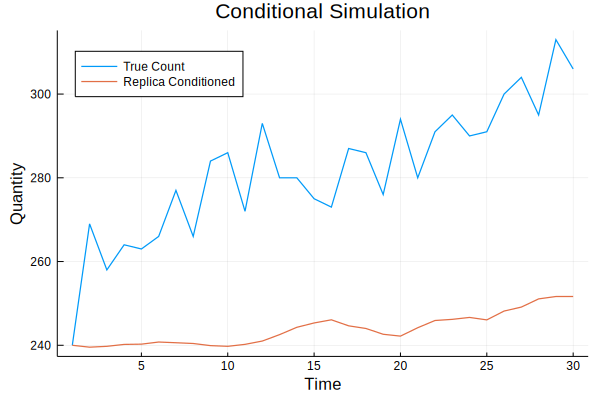

In [15]:
x_vals = Any[]
push!(x_vals, starting_val)
sim_steps = Any[]
push!(sim_steps, starting_val_rand_var)

N = 30
for n in 2:N
    sim_ = ciid(x_sim, n-1, 336)
    sim = cond(sim_, sim_ ==ₛ day1_cell1[n])
    push!(sim_steps, sim)
end

Random.seed!(25)
sim_samples = rand(Tuple(sim_steps), 1, alg = Replica, temps = [100,1000,10000,20000])
sim_samples = [sim_samples[1][x] for x in 1:length(sim_samples[1])]#.data

plot(hcat(day1_cell1[1:30], sim_samples),
    title = "Conditional Simulation",
    xlabel = "Time",
    ylabel = "Quantity",
    label = ["True Count" "Replica Conditioned"],
    lw = 1.25,
    legend = :topleft)

Even with updated temperature values we see the exact same results. Replica is theoretically the most flexible and accurate sampling algorithm available in Omega and we need to spend more time getting it to work.

Here we try HMC instead of Replica to see if we can get better results.

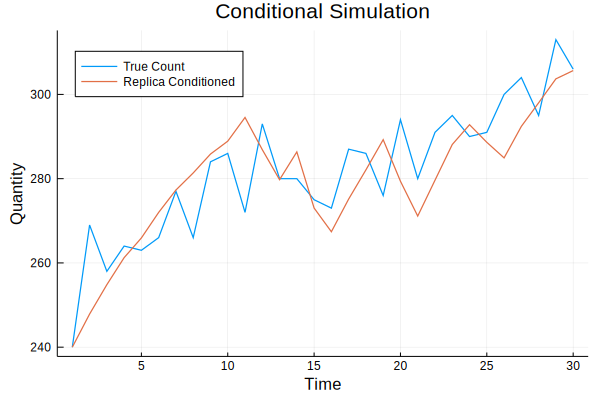

In [58]:
Omega.Soft.globalkernel!(kseα(15000))
x_vals = Any[]
push!(x_vals, starting_val)
sim_steps = Any[]
push!(sim_steps, starting_val_rand_var)

N = 30
for n in 2:N
    sim_ = ciid(x_sim, n-1, 336)
    sim = cond(sim_, sim_ ==ₛ day1_cell1[n])
    push!(sim_steps, sim)
end

#Random.seed!(25)
sim_samples = rand(Tuple(sim_steps), 1, alg = HMCFAST)
sim_samples = [sim_samples[1][x].data for x in 1:length(sim_samples[1])]#

plot(hcat(day1_cell1[1:30], sim_samples),
    title = "Conditional Simulation",
    xlabel = "Time",
    ylabel = "Quantity",
    label = ["True Count" "Replica Conditioned"],
    lw = 1.25,
    legend = :topleft)

With HMCFAST we can get pretty close to the conditioned trace. An issue with this strategy is that we need to manually set the alpha value. In a one off we can tune this, but it needs to be changed for each problem.

#### Intervention/Counterfactual

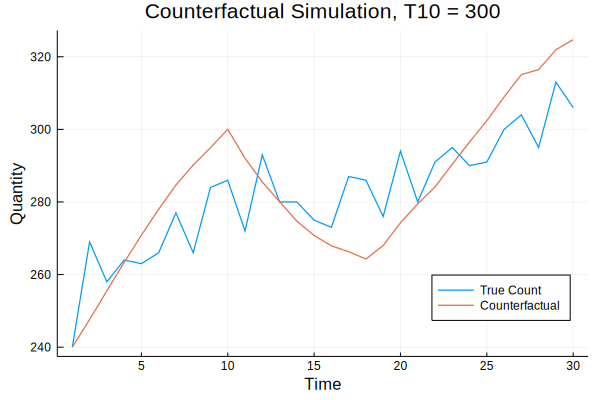

In [64]:
Omega.Soft.globalkernel!(kseα(8000))
x_vals = Any[]
push!(x_vals, starting_val)
sim_steps = Any[]
push!(sim_steps, starting_val_rand_var)

N = 30
for n in 2:N
    sim_ = ciid(x_sim, n-1, 336)
    sim = cond(sim_, sim_ ==ₛ day1_cell1[n])
    push!(sim_steps, sim)
end

intervention = 10
sim_steps[intervention] = replace(sim_steps[intervention], 
                                    sim_steps[intervention] => 300)

sim_samples = rand(Tuple(sim_steps), 1, alg = HMCFAST)

sim_samples = vcat([sim_samples[1][x].data for x in 1:(intervention-1)],
                    sim_samples[1][intervention],
                   [sim_samples[1][x].data for x in (intervention+1):length(sim_samples[1])])

plot(hcat(day1_cell1[1:30], sim_samples),
    title = "Counterfactual Simulation, T10 = 300",
    xlabel = "Time",
    ylabel = "Quantity",
    label = ["True Count" "Counterfactual"],
    lw = 1.25,
    legend = :bottomright)

Here we ask the counterfactual statement, "Given our observed data, what would the end count have been if we forced the count at Time 10 to be 300. Notice we had to lower the kernel parameter in order to reach a result.

## Gillespie Model

The model above was a simple formation that can be applied to this problem specifically. Can we expand this to Gillespie which is a much more universal simulation algorithm. Additionally does using gillespie give us more flexibility and allow for better results.

Note: This section needs more work.

In [65]:
function full_sim(rng, n, theta)
    
    """
    Function to sample from given hazard values. Takes previous species values and outputs the se3ected hazard and if that hazard was negative.
    """
    
    ecology = OrderedDict("S0" => S0_list[n](rng), "time" => time_list[n](rng))
    
    haz = OrderedDict(
        "H1" => theta["r1"],
        "H2" => ecology["S0"]*theta["r2"],
        "H3" => ecology["S0"]*theta["r3"]
        )
    
    t = Any[]
    for (key, value) in haz
        if value < 0
            haz[key] = 0 - value
            push!(t, 1)
        else 
            push!(t, 0)
        end
    end
    
    ## Get values from hazard dictionary
    vals = collect(values(haz))
    sum_vals = sum(vals)
    ## Calculate probabilities
    prob_vals = vals/sum_vals
    ## Sample
    hazard_result = categorical(rng, prob_vals)
    
    ## Track species values
    push!(S0_vals, ecology["S0"])
    push!(time_vals, ecology["time"])
    push!(reaction_samples, hazard_result)
    
    return hazard_result, t[hazard_result], sum_vals
    
end

function reaction_gen(rng, n)
    
    t_idx = ecology_list[n](rng)
    t = t_idx[1]
    return t
end

function S0_gen(rng, n, transition)
    
    """
    Individual function for each species. Need seperate random variables to apply interventions and conditionals.
    """
    
    t_idx = ecology_list[n](rng)
    t_sample = reaction_list[n](rng)
    update_val = deepcopy(transition[t_sample])
    if t_idx[2] == 1
        for idx in 1:length(update_val)
            update_val[idx] = 0 - update_val[idx]
        end
    end
    
    S0_val = S0_vals[n] + update_val[1]
    S0_val = max(0, S0_val)
    return S0_val
end
                            
function time_gen(rng, n)
    t_idx = ecology_list[n](rng)
    haz_sum = t_idx[3]
    time_val = time_vals[n] + exponential(rng, haz_sum)
    return time_val
end

function omega_simulation(theta, transition, starting_species, N_steps, seed)
    
    ## Initialize lists to hold random variables and species values
    global S0_list = Any[]; global ecology_list = Any[]
    global time_list = Any[]; global reaction_list = Any[]
    
    global S0_vals = []; global time_vals = []
    global reaction_samples = []
    
    ## Insert starting species values
    #insert!(S0_list, 1, normal(species["__s0"], .00001))
    insert!(S0_list, 1, uniform([starting_species["S0"]]))
    insert!(time_list, 1, uniform([0]))
    
    ## Create random variables for each step
    for f in 2:N_steps
        last = f - 1
        push!(ecology_list, ciid(full_sim, last, theta))
        push!(reaction_list, ciid(reaction_gen, last))
#         if n % 50 == 0
#             temp = ciid(S0_gen, last, transition)
#             push!(S0_list, cond(temp, sim_ ==ₛ condition_vals[(n / 50) + 1])
#         else
        push!(S0_list, ciid(S0_gen, last, transition))
#         end
        push!(time_list, ciid(time_gen, last))
    end

    ## Sample
    Random.seed!(seed)
    samples = rand(Tuple(ecology_list), 1, alg = RejectionSample)

    output = OrderedDict("S0" => S0_vals[1:N_steps-1], 
                        "time" => time_vals[1:N_steps-1], 
                        "reactions" => reaction_samples[1:N_steps-1])
    return output
    
end

function omega_simulation_cond(theta, transition, starting_species, N_steps, seed, condition_vals)
    
    ## Initialize lists to hold random variables and species values
    global S0_list = Any[]; global ecology_list = Any[]
    global time_list = Any[]; global reaction_list = Any[]
    
    global S0_vals = []; global time_vals = []
    global reaction_samples = []
    
    ## Insert starting species values
    #insert!(S0_list, 1, normal(species["__s0"], .00001))
    insert!(S0_list, 1, uniform([starting_species["S0"]]))
    insert!(time_list, 1, uniform([0]))
    
    ## Create random variables for each step
    for f in 2:N_steps
        last = f - 1
        push!(ecology_list, ciid(full_sim, last, theta))
        push!(reaction_list, ciid(reaction_gen, last))
        if f % 50 == 0
            temp = ciid(S0_gen, last, transition)
            push!(S0_list, cond(temp, temp ==ₛ condition_vals[Int((f / 50) + 1)]))
        else
            push!(S0_list, ciid(S0_gen, last, transition))
        end
        push!(time_list, ciid(time_gen, last))
    end

    ## Sample
    print("sample")
    Omega.Soft.globalkernel!(kseα(5000))
    Random.seed!(seed)
    samples = rand(Tuple(ecology_list, S0_list), 1, alg = HMCFAST)

    output = OrderedDict("S0" => S0_vals[1:N_steps-1], 
                        "time" => time_vals[1:N_steps-1], 
                        "reactions" => reaction_samples[1:N_steps-1])
    return output
    
end

omega_simulation_cond (generic function with 1 method)

In [66]:
## Transition Matrix
Pre = [[0], [0], [0]]
Post = [[1], [1], [-1]]
transition_mat = Post - Pre
species = OrderedDict("S0" => 240.)
# Rate Values
r1 = 2.51e-4
r2 = 10e-5
r3 = 10.5e-5
rates =  OrderedDict("r1" => r1,
         "r2" => r2,
         "r3" => r3)

OrderedDict{String,Float64} with 3 entries:
  "r1" => 0.000251
  "r2" => 0.0001
  "r3" => 0.000105

In [67]:
day1_cell1 = day1[day1.Cell .== 1, :count]
print()

In [68]:
## Initialize lists to hold random variables and species values
global S0_list = Any[]; global ecology_list = Any[]
global time_list = Any[]; global reaction_list = Any[]

global S0_vals = []; global time_vals = []
global reaction_samples = []

## Insert starting species values
#insert!(S0_list, 1, normal(species["__s0"], .00001))
insert!(S0_list, 1, uniform([species["S0"]]))
insert!(time_list, 1, uniform([0]))

## Create random variables for each step
for f in 2:120
    last = f - 1
    push!(ecology_list, ciid(full_sim, last, rates))
    push!(reaction_list, ciid(reaction_gen, last))
#     if f % 50 == 0
    temp = ciid(S0_gen, last, transition_mat)
    push!(S0_list, cond(temp, temp ==ₛ day1_cell1[f + 1]))
#     else
#     push!(S0_list, ciid(S0_gen, last, transition_mat))
#     end
    push!(time_list, ciid(time_gen, last))
end


In [71]:
sample_rand_var = (Tuple(S0_list))
print()

In [73]:
## Sample
Omega.Soft.globalkernel!(kseα(5000))
Random.seed!(5)
samples = rand(Tuple(S0_list), 1, alg = Replica)

temps = [2.06115e-9, 4.53999e-5, 1.0, 22026.5]
Chain at temp 2.061153622438558e-9 Failed due to:

UndefVarError(:categorical)
Chain at temp 4.539992976248485e-5 Failed due to:UndefVarError(:categorical)
Chain at temp 1.0 Failed due to:UndefVarError(:categorical)
Chain at temp 22026.465794806718 Failed due to:UndefVarError(:categorical)


UndefVarError: UndefVarError: categorical not defined

In [49]:
simple_sim = omega_simulation_cond(rates, transition_mat, species, 6000, 02, day1_cell1)

sample

MethodError: MethodError: no method matching memrand(::SimpleΩ{Array{Int64,1},TrackedArray{…,Array{Float64,1}}}, ::Array{Int64,1}, ::Array{Float64,1}; rng=MersenneTwister(UInt32[0x00000002], Random.DSFMT.DSFMT_state(Int32[-641910338, 1073498426, 723285883, 1072698796, -1488430546, 1073569104, -731969899, 1072832439, 428204485, 1073526484  …  -1507702375, 1073598657, -1605363939, 1073095897, -2041507079, 747155801, 735731947, -1871817892, 382, 0]), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], UInt128[0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000  …  0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000], 1002, 0))
Closest candidates are:
  memrand(::SimpleΩ{I,A<:TrackedArray}, ::I, !Matched::Type{T}; rng) where {T, I, A<:TrackedArray} at C:\Users\Devon Kohler\.julia\packages\Omega\zOdli\src\space\simple.jl:78
  memrand(::SimpleΩ{I,A<:TrackedArray}, ::I, !Matched::Type{T}, !Matched::Tuple{Vararg{Int64,N}} where N; rng) where {T, I, A<:TrackedArray} at C:\Users\Devon Kohler\.julia\packages\Omega\zOdli\src\space\simple.jl:72
  memrand(::SimpleΩ{I,A<:(AbstractArray{V,N} where N)}, ::Any, !Matched::Type{T}; rng) where {V, T, I, A<:(AbstractArray{V,N} where N)} at C:\Users\Devon Kohler\.julia\packages\Omega\zOdli\src\space\simple.jl:49
  ...

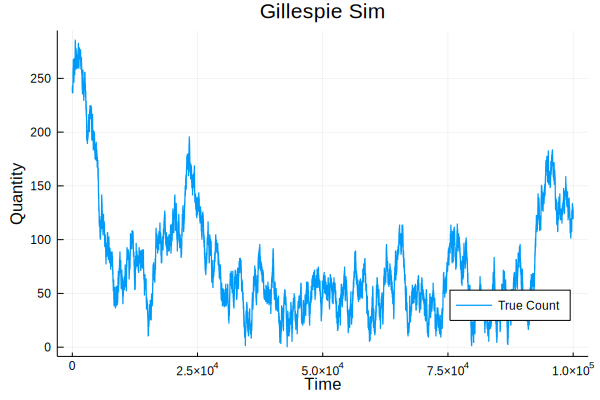

In [25]:
plot(simple_sim["S0"],
    title = "Gillespie Sim",
    xlabel = "Time",
    ylabel = "Quantity",
    label = ["True Count" "Counterfactual"],
    lw = 1.25,
    legend = :bottomright)